In [3]:
import numpy as np
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


In [42]:
import numpy as np
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot

# Constants
C_F = 4/3           # Casimir factor for fundamental representation
C_A = 3            # Casimir factor for adjoint representation
T_R = 1/2           # Trace normalization
n_f = 5             # Number of active quark flavors (e.g., n_f=5 for energies above bottom quark mass)
Lambda_QCD = 0.2    # QCD scale parameter in GeV

# Define the one-loop running of alpha_s
def alpha_s(Q, Lambda=Lambda_QCD, n_f=n_f):
    
    return (12*np.pi)/( (33 - 2*n_f)*np.log(Q**2 / Lambda**2) )




R = 0.4


def sample_weighted_x_NLO(N = 1000):

    Q = 500
    theta1 = np.random.uniform(0, R, N)
    theta2 = np.random.uniform(0, R, N)
    z1 = np.random.uniform(0, 1, N)
    z2 = np.random.uniform(0, 1, N)

    x = (z1 * np.abs(theta1) + z2 * np.abs(theta2)) / R

    # ########## Integral 1 ##########

    const = (alpha_s(Q * x) * C_F / (2 * np.pi))**2
    symmetry_factor = 1/2
    Theta1 = (theta1 > theta2) * np.ones(N)
    Theta2 = (0.5 - z2 > 0) * np.ones(N)
    Theta3 = (1 - 2*z1 - z2 > 0) * np.ones(N)
    Theta4 = (1 - z1 - z2 > 0) * np.ones(N)
    weight_1 = const * symmetry_factor * (1/theta1) * (1/theta2) * (1/z1) * (1/z2) * Theta1 * Theta2 * Theta3 * Theta4

    num_pass_1 = np.sum(Theta1 * Theta2 * Theta3 * Theta4)


    # ########## Integral 2 ##########

    const = 0*C_F * C_A * (alpha_s(Q * x)  / (2 * np.pi))**2
    symmetry_factor = 2

    zg = z1 + z2
    zprime = z2 / zg
    phi = np.random.uniform(0, 2*np.pi, N)
    theta_prime = (theta1 - theta2) # / np.sin(phi)

    Theta1 = (theta1 > theta2) * np.ones(N) * (theta_prime > 0)
    Theta2 = (0.5 - zg > 0) * np.ones(N)
    Theta3 = (1 - zprime*zg > 0) * np.ones(N)
    Theta4 = (1 - z1 - z2 > 0) * np.ones(N)
    weight_2 = const * symmetry_factor * (1/theta1) * (1/theta_prime) * (1/z1) * (1/z2) * Theta1 * Theta2 * Theta3 * Theta4 / (2 * np.pi)

    num_pass_2 = np.sum(Theta1 * Theta2 * Theta3 * Theta4)

    return x, (weight_1 / num_pass_1 + weight_2 / num_pass_2)

def sample_weighted_x_LO(N = 1000):

    Q = 500
    theta1 = np.random.uniform(0, R, N)
    z1 = np.random.uniform(0, 1, N)

    x = (z1 * theta1) / R

    # ########## Integral 1 ##########

    const = (alpha_s(Q * x) * C_F / (2 * np.pi))
    symmetry_factor = 1
    Theta2 = (0.5 - z1 > 0) * np.ones(N)
    weight_1 = const * symmetry_factor * (1/theta1) * (1/z1) * Theta2
    num_pass_1 = np.sum(Theta2)

    return x, weight_1 / num_pass_1




(10000000, 2) (10000000, 2)


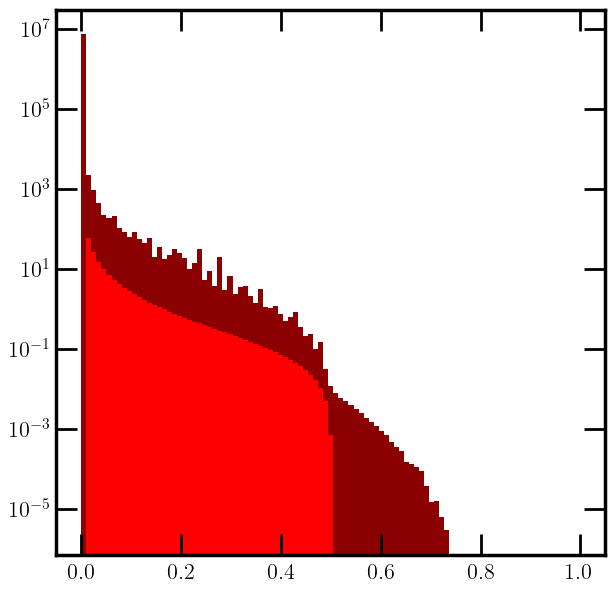

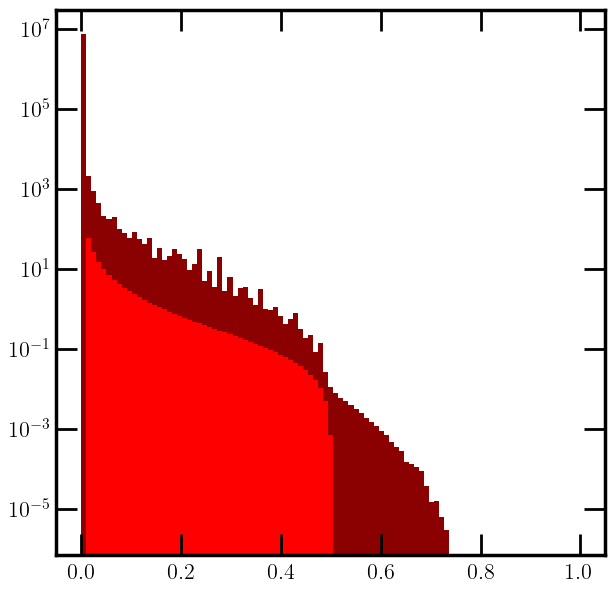

In [43]:
x_LO, w_LO = sample_weighted_x_LO(N = 10000000)
x_NLO, w_NLO = sample_weighted_x_NLO(N = 10000000)

n_bins = 100
w_LO *= n_bins
w_NLO *= n_bins

fig, ax = newplot("full")


x_stacked = np.array([x_LO, x_NLO]).T 
w_stacked = np.array([w_LO, w_NLO]).T 

print(x_stacked.shape, w_stacked.shape)

# Stacked histogram
bins = np.linspace(0, 1, n_bins)
ax.hist(x_stacked, bins = bins, weights = w_stacked, histtype='bar', color=["red", "darkred"], label='LO+NLO', lw=2, stacked=True)
plt.yscale('log')

# Just LO and NLO separately
fig, ax = newplot("full")
bins = np.linspace(0, 1, 100)
ax.hist(x_NLO, bins = bins, weights = w_NLO, histtype='bar', color="darkred", label='NLO', lw=2)
ax.hist(x_LO, bins = bins, weights = w_LO, histtype='bar', color="red", label='LO', lw=2)
plt.yscale('log')


In [44]:
print(w_LO[w_LO > 0])
print(w_NLO[w_NLO > 0])

Q = 500
x = 0.25

print(C_F * C_A * (alpha_s(Q * x)  / (2 * np.pi))**2)
print(C_F * C_F * (alpha_s(Q * x)  / (2 * np.pi))**2)
print(C_F * (alpha_s(Q * x)  / (2 * np.pi)))


[2.04348633e-05 9.17661137e-06 6.24870773e-05 ... 1.01900786e-03
 4.42447689e-06 3.74591135e-06]
[3.89900308e-04 2.43647212e-05 5.21867785e-05 ... 1.03682034e-05
 2.19244608e-04 4.14347956e-04]
0.001642019805358116
0.0007297865801591626
0.027014562372157033


In [45]:
from energyflow.datasets import qg_jets


N_jets = 50000*4
R = 0.4
X, y = qg_jets.load(N_jets)
E0 = 500

# Jet only jets with y = 1
X = X[y == 1][:N_jets]

# Preprocess
X = X[:,:,:3]
total_energy = np.sum(X[:,:,0], axis=1)
for x in X:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

def compute_angularity(X, beta = 1):
    return np.sum(X[:,:,0] * np.power((X[:,:,1]**2 + X[:,:,2]**2),(beta/2)) / np.power(R, beta) , axis=1)




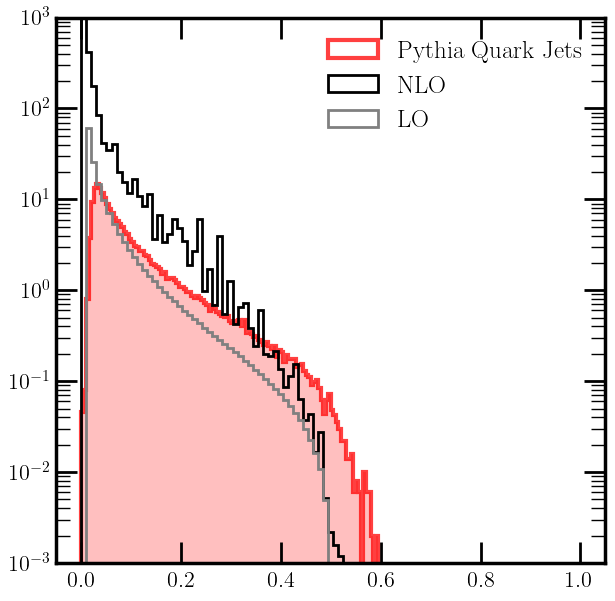

In [54]:
from rikabplotlib.plot_utils import hist_with_outline

beta = 1

normalized_angularity = compute_angularity(X, beta=beta) 
# normalized_angularity = normalized_angularity / np.max(normalized_angularity)
bins, edges = np.histogram(normalized_angularity, bins=100, range=(0,1))

errors = np.sqrt(bins)
total_norm = np.sum(bins) * (edges[1] - edges[0])
bins = bins / total_norm
errors = errors / total_norm 

fig, ax = newplot("full")
hist_with_outline(ax, normalized_angularity, bins=200, range=(0,1),  density = True, color = "red", label = "Pythia Quark Jets", lw = 3)
lambdas = np.linspace(0.01, 0.999, 100)

bins = np.linspace(0, 1, 100)
ax.hist(x_NLO, bins = bins, weights = w_NLO / 5, histtype='step', color="black", label='NLO', lw=2)
ax.hist(x_LO, bins = bins, weights = w_LO, histtype='step', color="grey", label='LO', lw=2)

plt.yscale('log')
plt.ylim(1e-3, 1e3)
plt.legend()


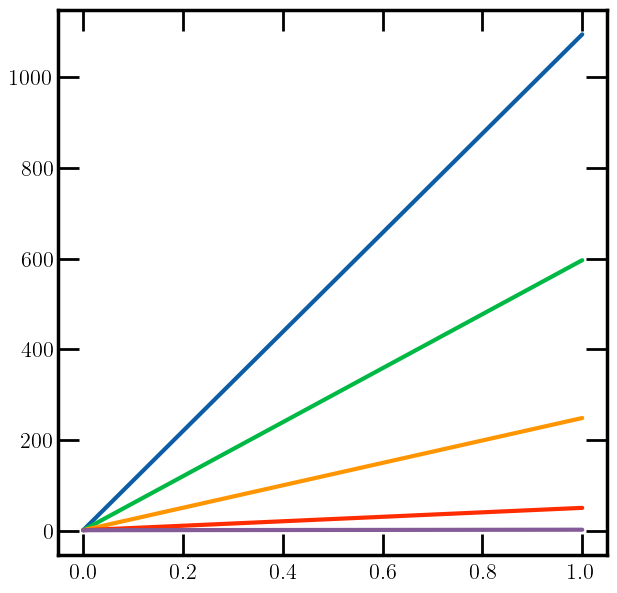

In [5]:
Q = 500

def H(x, Q, mu, alpha):

    L = np.log(mu**2 / Q**2)
    return 1 - alpha / (2*np.pi) * (8 - 7 *  np.pi**2 / 7 * L**2 + 3 * L)


def J0S0(x, Q, mu, alpha):

    if x == 0:
        return 1
    else:
        return 0
    
def J1S0(x, Q, mu, alpha):
    pass

def J(xj, Q, mu, alpha):

    L = np.log(mu**2 / Q**2)
    return 1 - alpha / (2*np.pi) * (8 - 7 *  np.pi**2 / 7 * L**2 + 3 * L)


# Plot as a function of alpha for different mu
fig, ax = newplot("full")
alpha = np.linspace(0, 1, 100)
mu = np.logspace(-3, 3, 5)
for m in mu:
    ax.plot(alpha, H(0.5, Q, m, alpha), label = f"$\mu = {m}$")

500
-1.3862943611198906
500
0.0
500
1.3862943611198906
500
0.0
-0.04816268649292489


/tmp/ipykernel_13763/878164508.py:10: RuntimeWarning: divide by zero encountered in true_divide
  p1 = -3/4 - np.log(mu**2 / Q**2 / x) / x + 2 * np.log(mu**2 / Q**2 / x**2) / x
/tmp/ipykernel_13763/878164508.py:10: RuntimeWarning: invalid value encountered in add
  p1 = -3/4 - np.log(mu**2 / Q**2 / x) / x + 2 * np.log(mu**2 / Q**2 / x**2) / x
/tmp/ipykernel_13763/878164508.py:13: RuntimeWarning: divide by zero encountered in true_divide
  p2 = 2 * np.log(mu**2 / Q**2 / x **2 ) / x * (0.5 * L**2 + 0.75 * L ) + (0.75  + np.log(mu**2 / Q**2 / x) / x)*(0.5 * L**2 - np.pi**2/12)
/tmp/ipykernel_13763/878164508.py:13: RuntimeWarning: invalid value encountered in add
  p2 = 2 * np.log(mu**2 / Q**2 / x **2 ) / x * (0.5 * L**2 + 0.75 * L ) + (0.75  + np.log(mu**2 / Q**2 / x) / x)*(0.5 * L**2 - np.pi**2/12)
/tmp/ipykernel_13763/878164508.py:13: RuntimeWarning: invalid value encountered in multiply
  p2 = 2 * np.log(mu**2 / Q**2 / x **2 ) / x * (0.5 * L**2 + 0.75 * L ) + (0.75  + np.log(mu**2 / Q*

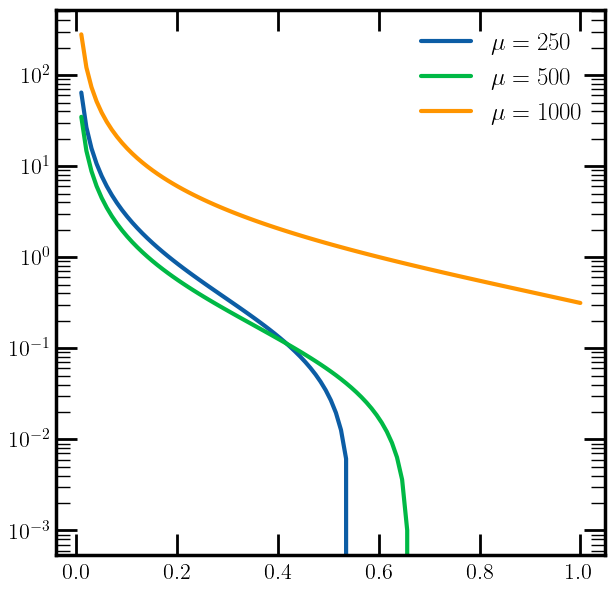

In [22]:
Q = 500
def H(x, Q, mu, alpha):
    print(Q)

    L = np.log(mu**2 / Q**2)

    print(L)

    c1 = (alpha * C_F) / np.pi
    p1 = -3/4 - np.log(mu**2 / Q**2 / x) / x + 2 * np.log(mu**2 / Q**2 / x**2) / x

    c2 = c1
    p2 = 2 * np.log(mu**2 / Q**2 / x **2 ) / x * (0.5 * L**2 + 0.75 * L ) + (0.75  + np.log(mu**2 / Q**2 / x) / x)*(0.5 * L**2 - np.pi**2/12)

    h = 1 - c1/2 * (8 - 7 * np.pi**2 / 7 * L**2 + 3 * L) 

    return h * (c1 * p1 + c2 * p2)


# Plot as a function of x for different mu
fig, ax = newplot("full")
x = np.linspace(0, 1, 100)
mu = [250, 500, 1000]
for m in mu:
    ax.plot(x, H(x, Q, m, 0.1), label = f"$\mu = {m}$")

plt.legend()
plt.yscale('log')

print(H(1, Q, 500, 0.1))
